<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Predicting Websites Traffic Based on Twitter Activity Project Technical Document

_Author: Daniyah Aldawsari_

---

# Problem Statment
    revisiting our hypothesis:
- **solution** finding a function that can predict website traffic based on twitter activity.
- **success** managing to teach the model using the freely accessable data to predict the website traffic with the smallest possible margine of error.
- **Null hypothesis H0:** twitter account activities doesn't effect the websites traffic .
- **Alternate hypothesis:** the more active this account is (likes - retweets - number of actual tweets) the more traffic the websites will recieve.

# Summarizing the EDA
    details of the EDA can be found in the EDA notebook
We will plot the heatmap, pairplot and some box plot

In [7]:
# Importing all necessary libraries
import os, json
import pandas as pd
import glob
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import preprocessing
from sklearn.preprocessing import scale
import scipy
import plotly.plotly as py
import plotly.figure_factory as ff
import plotly.graph_objs as go
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')

In [8]:
df = pd.read_csv('clean-data-final.csv')

In [9]:
df.shape

(6956, 86)

In [10]:
df.views.min()

3.7508086799956035

## Set Feature df and target variable

In [11]:
X = df[df.columns.difference(['link_to_tweet','date', 'twitter_user', 'website_x'
                              , 'name', 'homepage_domain', 'website_y', 'views'
                              , 'twitter_url', 'location_country_code', 'log1p_transform'
                              , 'short_description', 'username', 'reach_per_million'
                              , 'categories_x', 'homepage_url', 'Unnamed: 0', 'Unnamed: 0.1'
                              ,'categories_y','categories', 'crunchbase_url' , 'speed_percentile'
                              , 'crunchbase_uuid', 'facebook_url', 'timezone', 'median_load_time'
                             , 'type', 'stock_symbol', 'mentions_sum', 'primary_role'
                              ,'profile_image_url', 'hashtags_total', 'linkedin_url'
                             , 'location_city', 'location_region'])]
y = df['log1p_transform']
merged = df[df.columns.difference(['link_to_tweet','date', 'twitter_user', 'website_x'
                              , 'name', 'homepage_domain', 'website_y', 'views'
                              , 'twitter_url', 'location_country_code', 'median_load_time'
                              , 'short_description', 'username', 'reach_per_million'
                              , 'categories_x', 'homepage_url', 'Unnamed: 0', 'Unnamed: 0.1'
                              ,'categories_y','categories', 'crunchbase_url' 
                              , 'crunchbase_uuid', 'facebook_url', 'timezone', 'speed_percentile'
                             , 'type', 'stock_symbol', 'mentions_sum', 'primary_role'
                              ,'profile_image_url', 'hashtags_total', 'linkedin_url'
                             , 'location_city', 'location_region'])]

In [12]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6956 entries, 0 to 6955
Data columns (total 52 columns):
AE                              6956 non-null int64
Arts & Entertainment            6956 non-null int64
Automotive                      6956 non-null int64
BH                              6956 non-null int64
Business                        6956 non-null int64
Buying/Selling Cars             6956 non-null int64
Careers                         6956 non-null int64
Cell Phones                     6956 non-null int64
DZ                              6956 non-null int64
Data Centers                    6956 non-null int64
EG                              6956 non-null int64
Education                       6956 non-null int64
Family & Parenting              6956 non-null int64
Food & Drink                    6956 non-null int64
Health & Fitness                6956 non-null int64
Hobbies & Interests             6956 non-null int64
Home & Garden                   6956 non-null int64
IQ       

## Top 10 correlated attributes

In [13]:
X.iloc[:,:].corrwith(y).sort_values(ascending = False)[:10]

links_in_count                  0.395702
followers_count                 0.395435
likes                           0.276537
replies                         0.260767
retweets                        0.246775
hashtags_count                  0.242436
total_tweets                    0.213985
News / Weather / Information    0.204437
word_count                      0.182073
Non-Standard Content            0.160943
dtype: float64

## Correlation Heatmap

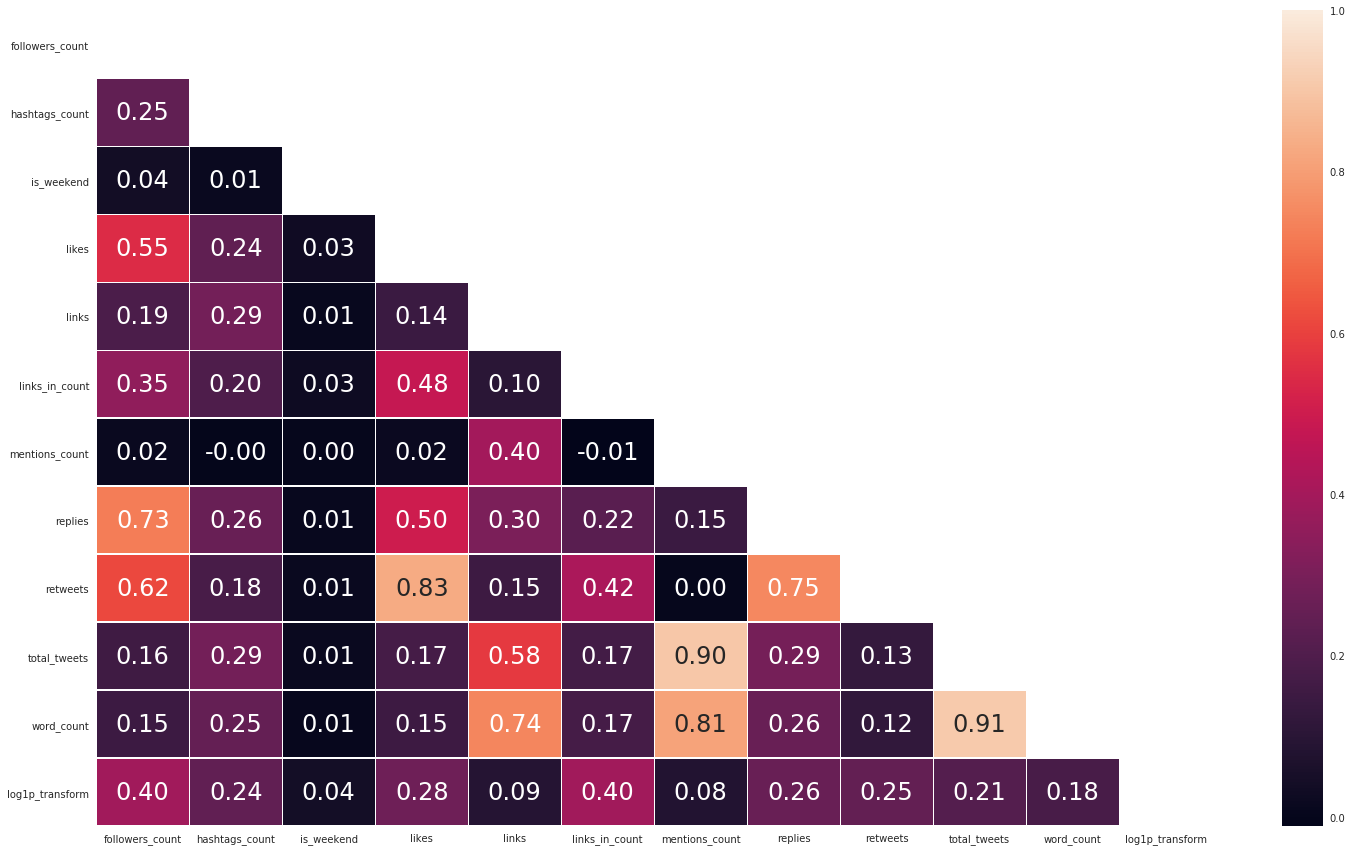

In [342]:
plt.figure(figsize=(25,15))
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 24}
plt.rc('font', **font)
corr = X.join(y).iloc[:,41:].corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr,mask= mask, annot=True,linewidth=0.4, fmt=".2f")

In [16]:
import random 
def generate_subset(df, column):
    """
    mask a dataframe and return target column as a series

    Parameters
    ----------
    df : DataFrame
        Dataframe to be filtered
    column : str
        column name of dummy column to filter based on

    Returns
    -------
    Target variable Series for filtered dummy column
        After filtering the Dataframe based on dummy variable column select
        and return the target

    """
    return df[df[column] == 1]['log1p_transform']

## Distribution of target variable across different categories

In [17]:
# Plot boxplot based on top 5 listed categories 
# Those were chosen to allow a fair distribution of samples
columns = ['News / Weather / Information', 'Personal Finance'
         , 'Technology & Computing', 'Business', 'Shopping',
          'Travel']
x_data = columns
y_data = []
colors = []
for i in columns:
    y_data.append(generate_subset(merged,i))
colors = ['rgba(93, 164, 214, 0.5)', 'rgba(255, 144, 14, 0.5)', 'rgba(44, 160, 101, 0.5)',
          'rgba(255, 65, 54, 0.5)', 'rgba(207, 114, 255, 0.5)', 'rgba(127, 96, 0, 0.5)']
traces = []

# Generate box plot for each group
for xd, yd, cls in zip(x_data, y_data, colors):
        traces.append(go.Box(
            y=yd,
            name=xd,
            boxpoints='all',
            jitter=0.5,
            whiskerwidth=0.2,
            fillcolor=cls,
            marker=dict(
                size=2,
            ),
            line=dict(width=1),
        ))

# Set up the layout
layout = go.Layout(
    title='Views 5 categories',
    yaxis=dict(
        autorange=True,
        showgrid=True,
        zeroline=True,
        dtick=5,
        gridcolor='rgb(255, 255, 255)',
        gridwidth=1,
        zerolinecolor='rgb(255, 255, 255)',
        zerolinewidth=2,
    ),
    margin=dict(
        l=40,
        r=30,
        b=80,
        t=100,
    ),
    paper_bgcolor='rgb(243, 243, 243)',
    plot_bgcolor='rgb(243, 243, 243)',
    showlegend=False
)

fig = go.Figure(data=traces, layout=layout)
py.iplot(fig)

KeyboardInterrupt: 

The key thing to take from the graph is how popular news and shopping sites are compared to other categories.

## Distribution of target variable across different countries

In [100]:
columns = ['AE', 'SA'
         , 'EG']
x_data = columns
y_data = []
colors = []
for i in columns:
    y_data.append(generate_subset(merged,i))
colors = ['rgba(93, 164, 214, 0.5)', 'rgba(255, 144, 14, 0.5)', 'rgba(44, 160, 101, 0.5)', 'rgba(255, 65, 54, 0.5)', 'rgba(207, 114, 255, 0.5)', 'rgba(127, 96, 0, 0.5)']
traces = []

for xd, yd, cls in zip(x_data, y_data, colors):
        traces.append(go.Box(
            y=yd,
            name=xd,
            boxpoints='all',
            jitter=0.5,
            whiskerwidth=0.2,
            fillcolor=cls,
            marker=dict(
                size=2,
            ),
            line=dict(width=1),
        ))

layout = go.Layout(
    title='Views for top 5 countries',
    yaxis=dict(
        autorange=True,
        showgrid=True,
        zeroline=True,
        dtick=5,
        gridcolor='rgb(255, 255, 255)',
        gridwidth=1,
        zerolinecolor='rgb(255, 255, 255)',
        zerolinewidth=2,
    ),
    margin=dict(
        l=40,
        r=30,
        b=80,
        t=100,
    ),
    paper_bgcolor='rgb(243, 243, 243)',
    plot_bgcolor='rgb(243, 243, 243)',
    showlegend=False
)

fig = go.Figure(data=traces, layout=layout)
py.iplot(fig)

Countries are a bit more evenly spread out thank the categories

## Pairplot

In [101]:
# Colorize based on weekend\weekday
color_vals = [0  if cl==0 else 1 for cl in merged['is_weekend']]
pl_colorscaled = [[0., '#119dff'],
                 [0.5, '#119dff'],
                 [0.5, '#ef553b'],
                 [1, '#ef553b']]
# Create the main scatterplot object and specify the axis
traced = go.Splom(dimensions=[dict(label='log1p Y variable', values=merged['log1p_transform']),
                              dict(label='followers_count', values=merged['followers_count']),
                              dict(label='hashtags_count', values=merged['hashtags_count']),
                              dict(label='retweets', values=merged['retweets']),
                              dict(label='links_in_count', values=merged['links_in_count']),
                              dict(label='likes', values=merged['likes']),
                              dict(label='total_tweets', values=merged['total_tweets']),
                              dict(label='replies', values=merged['replies']),
                              dict(label='word_count', values=merged['word_count'])],
                  marker=dict(color=color_vals,
                              size=5,
                              colorscale=pl_colorscaled,
                              line=dict(width=0.5,
                                        color='rgb(230,230,230)') ),
                  diagonal=dict(visible=False))

axisd = dict(showline=False,
           zeroline=False,
           gridcolor='#fff',
           ticklen=4,
           titlefont=dict(size=13))
title = "Scatterplot Matrix (SPLOM) for Predicting Companies Activities Dataset"

layout = go.Layout(title=title,
                   dragmode='select',
                   width=1000,
                   height=1000,
                   autosize=False,
                   hovermode='closest',
                   plot_bgcolor='rgba(240,240,240, 0.95)',
                   xaxis1=dict(axisd),
                   yaxis1=dict(axisd),
                   yaxis2=dict(axisd),
                   yaxis3=dict(axisd),
                   yaxis4=dict(axisd),
                   yaxis5=dict(axisd),
                   yaxis6=dict(axisd),
                   yaxis7=dict(axisd),
                   yaxis8=dict(axisd))

fig = dict(data=[traced], layout=layout)
py.iplot(fig, filename='test')

Overall we can see a relation between the predicted variable and our features (not necessarily linear)

## Dealing with multicolinearity


In [18]:
# This Class is taken from https://www.kaggle.com/ffisegydd/sklearn-multicollinearity-class
# Extra imports necessary for the code
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import Imputer
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.outliers_influence import variance_inflation_factor

class ReduceVIF(BaseEstimator, TransformerMixin):
    def __init__(self, thresh=5.0, impute=True, impute_strategy='median'):
        # From looking at documentation, values between 5 and 10 are "okay".
        # Above 10 is too high and so should be removed.
        self.thresh = thresh        
        # The statsmodel function will fail with NaN values, as such we have to impute them.
        # By default we impute using the median value.
        # This imputation could be taken out and added as part of an sklearn Pipeline.
        if impute:
            self.imputer = Imputer(strategy=impute_strategy)

    def fit(self, X, y=None):
        print('ReduceVIF fit')
        if hasattr(self, 'imputer'):
            self.imputer.fit(X)
        return self

    def transform(self, X, y=None):
        print('ReduceVIF transform')
        columns = X.columns.tolist()
        if hasattr(self, 'imputer'):
            X = pd.DataFrame(self.imputer.transform(X), columns=columns)
        return ReduceVIF.calculate_vif(X, self.thresh)

    @staticmethod
    def calculate_vif(X, thresh=5.0):
        # Taken from https://stats.stackexchange.com/a/253620/53565 and modified
        dropped=True
        while dropped:
            variables = X.columns
            dropped = False
            vif = [variance_inflation_factor(X[variables].values, X.columns.get_loc(var)) for var in X.columns]
            
            max_vif = max(vif)
            if max_vif > thresh:
                maxloc = vif.index(max_vif)
                print(f'Dropping {X.columns[maxloc]} with vif={max_vif}')
                X = X.drop([X.columns.tolist()[maxloc]], axis=1)
                dropped=True
        return X

In [19]:
transformer = ReduceVIF()
X = transformer.fit_transform(X, y)
X.head()

ReduceVIF fit
ReduceVIF transform
Dropping AE with vif=33.94833269474956
Dropping total_tweets with vif=25.992874935373653
Dropping word_count with vif=12.237225397857792
Dropping retweets with vif=7.5634042154404115


Arts & Entertainment  Automotive   BH  Business  Buying/Selling Cars  \
0                   0.0         0.0  0.0       0.0                  0.0   
1                   0.0         0.0  0.0       0.0                  0.0   
2                   0.0         0.0  0.0       0.0                  0.0   
3                   0.0         0.0  0.0       0.0                  0.0   
4                   0.0         0.0  0.0       0.0                  0.0   

   Careers  Cell Phones   DZ  Data Centers   EG   ...     \
0      0.0          0.0  0.0           0.0  0.0   ...      
1      0.0          0.0  0.0           0.0  0.0   ...      
2      0.0          0.0  0.0           0.0  0.0   ...      
3      0.0          0.0  0.0           0.0  0.0   ...      
4      0.0          0.0  0.0           0.0  0.0   ...      

   Technology & Computing  Travel  followers_count  hashtags_count  \
0                     1.0     0.0             83.0             4.0   
1                     1.0     0.0             83.0             3.0   
2                     1.0     0.0             83.0             5.0   
3                     1.0     0.0             83.0             4.0   
4                     1.0     0.0             83.0             5.0   

   is_weekend  likes  links  links_in_count  mentions_count  replies  
0         0.0    0.0    0.0             9.0             0.0      0.0  
1         0.0    0.0    0.0             9.0             0.0      0.0  
2         0.0    0.0    0.0             9.0             0.0      0.0  
3         0.0    0.0    0.0             9.0             0.0      0.0  
4         0.0    1.0    0.0             9.0             0.0      0.0  

[5 rows x 48 columns]

# Modeling

## Create test/train split

In [20]:
RANDOM_STATE = 0
# Given that our data sample is wide enough we will do a 70/30 split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3, random_state=RANDOM_STATE)

## Modeling options
Models to try:
- Random Forest Regressor  
- Extra Trees Regressor  
- K-nn Regressor

We will Evaluate the performance using the below metrics
- MAE over RMSE: Because it is robust against outliers
- Adjusted R2 over R2: To evaluate the fit while capture effect of number of independant variables

In [21]:
def generate_model_report(model, X_train, y_train, X_test, y_test):
    results = dict()
    # R2
    y_test_predict = dict()
    # The root mean squared error (After Exponentiating)
    y_test_root_mean_squared_error = dict()
    # The median absolute error 
    y_test_median_absolute_error = dict()
    # The Mean Absolute Error
    y_test_mean_absolute_error = dict()
    #R2 Adjusted
    adjusted_r2 = dict()
    model.fit(X_train, y_train)
    # Y Predict Exponentiated
    y_pred_exp1 = np.expm1(model.predict(X_test))
    y_pred_train_exp1 = np.expm1(model.predict(X_train))
    results['R2'] = model.score(X_test,y_test)
    results['RMSE'] = np.sqrt(mean_squared_error(np.expm1(y_test) , y_pred_exp1))
    results['Median_Absolute_Error'] = median_absolute_error(np.expm1(y_test), y_pred_exp1)
    results['MAE'] = mean_absolute_error(np.expm1(y_test), y_pred_exp1)
    results['Adjusted_R2'] = 1 - (1-results['R2'])*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)    
    results['RMSE_Train'] = np.sqrt(mean_squared_error(np.expm1(y_train) , y_pred_train_exp1))
    results['MAE_Train'] = mean_absolute_error(np.expm1(y_train), y_pred_train_exp1)
    
    return results

In [22]:
# We will first Use the default setting

from sklearn.utils.validation import check_random_state
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn import ensemble
from sklearn.metrics import mean_squared_error, r2_score, median_absolute_error,\
mean_absolute_error
from sklearn.linear_model import Ridge
import statsmodels.api as sm
from scipy import stats
from sklearn.linear_model import Lasso

# Fit estimators
ESTIMATORS = {
    "Extra trees": ExtraTreesRegressor(random_state=RANDOM_STATE),
    "K-nn": KNeighborsRegressor( n_neighbors= 20),
    "Random Forest Regressor": RandomForestRegressor(random_state=RANDOM_STATE)
}

# R2
y_test_predict = dict()
# The root mean squared error 
y_test_root_mean_squared_error = dict()
y_test_root_mean_squared_error_train = dict()
# The median absolute error 
y_test_median_absolute_error = dict()
# The Mean Absolute Error
y_test_mean_absolute_error = dict()
y_test_mean_absolute_error_train = dict()

adjusted_r2 = dict()
for name, estimator in ESTIMATORS.items():
    results = generate_model_report(estimator, X_train,y_train, X_test, y_test)
    y_test_predict[name] = results['R2']
    y_test_root_mean_squared_error[name] = results['RMSE']
    y_test_root_mean_squared_error_train[name] = results['RMSE_Train']
    y_test_median_absolute_error[name] = results['Median_Absolute_Error']
    y_test_mean_absolute_error[name] = results['MAE']
    y_test_mean_absolute_error_train[name] = results['MAE_Train']
    adjusted_r2[name] = results['Adjusted_R2']

In [507]:
import pprint
print("R2 Score")
pprint.pprint(y_test_predict)
print("Root Mean Squared Error on Test Data")
pprint.pprint(y_test_root_mean_squared_error)
print("Root Mean Squared Error on Train Data")
pprint.pprint(y_test_root_mean_squared_error_train)
print("Median Absolute Error")
pprint.pprint(y_test_median_absolute_error)
print("Mean Absolute Error")
pprint.pprint(y_test_mean_absolute_error)
print("Mean Absolute Error Train")
pprint.pprint(y_test_mean_absolute_error_train)
print("Adjusted R2")
pprint.pprint(adjusted_r2)

R2 Score
{'Extra trees': 0.942528976254632,
 'K-nn': 0.8530571262410234,
 'Random Forest Regressor': 0.9454135395333964}
Root Mean Squared Error on Test Data
{'Extra trees': 18671.163174061578,
 'K-nn': 23066.229545112896,
 'Random Forest Regressor': 20850.476336483865}
Root Mean Squared Error on Train Data
{'Extra trees': 985.0503146191832,
 'K-nn': 24485.985445036506,
 'Random Forest Regressor': 9867.611580433704}
Median Absolute Error
{'Extra trees': 647.7158479558857,
 'K-nn': 1275.6686091807194,
 'Random Forest Regressor': 649.6809297866736}
Mean Absolute Error
{'Extra trees': 5792.4938099528945,
 'K-nn': 8524.57783030138,
 'Random Forest Regressor': 6442.763340451086}
Mean Absolute Error Train
{'Extra trees': 117.76090087295601,
 'K-nn': 8809.345378179461,
 'Random Forest Regressor': 2801.1992572776585}
Adjusted R2
{'Extra trees': 0.9411753898268705,
 'K-nn': 0.8495962538463075,
 'Random Forest Regressor': 0.944127891789335}


In [508]:
import plotly.plotly as py
import plotly.graph_objs as go

trace1 = go.Bar(
    x=list(y_test_root_mean_squared_error.keys()),
    y=list(y_test_root_mean_squared_error.values()),
    name='Root Mean Squared Error',
    marker=dict(
        color='rgb(204,204,204)',
    )
)
trace2 = go.Bar(
    x=list(y_test_mean_absolute_error.keys()),
    y=list(y_test_mean_absolute_error.values()),
    name='Mean Absolute Error',
    marker=dict(
        color='rgb(127,163,129)',
    )
)

data = [trace1, trace2]
layout = go.Layout(
    xaxis=dict(tickangle=-45),
    barmode='group',
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='angled-text-bar')

In [25]:
# Plot the distribution of the Residual & Prediciton Errors
from yellowbrick.regressor import ResidualsPlot
from yellowbrick.regressor import PredictionError
from yellowbrick.style import set_palette
def plot_visualizer(estimator, X_train, y_train, X_test, y_test):
    plt.subplot()
    visualizer = ResidualsPlot(estimator)
    visualizer.fit(X_train, y_train)  # Fit the training data to the model
    visualizer.score(X_test, y_test)  # Evaluate the model on the test data
    visualizer.poof()                 # Draw/show/poof the data
def plot_error_prediction(estimator, X_train, y_train, X_test, y_test):
    plt.subplot()
    visualizer = PredictionError(estimator)
    visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
    visualizer.score(X_test, y_test)  # Evaluate the model on the test data
    visualizer.poof()  

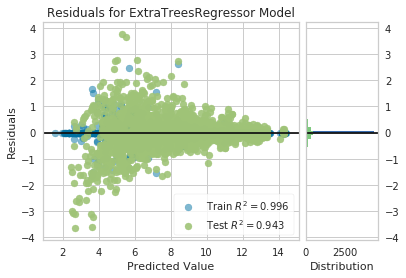

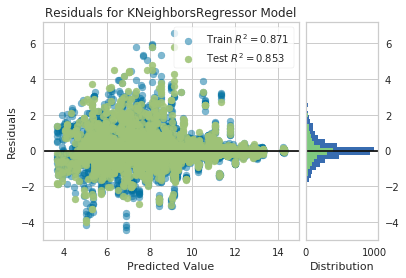

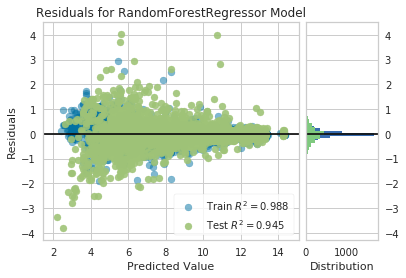

In [510]:
for name, estimator in ESTIMATORS.items():
    plot_visualizer(estimator, X_train, y_train, X_test, y_test)

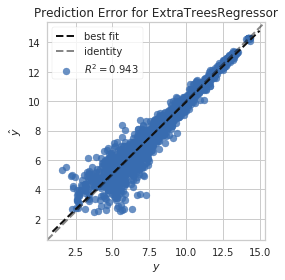

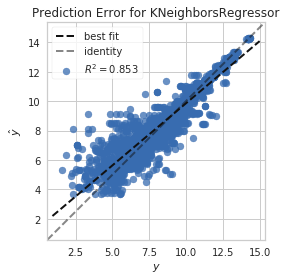

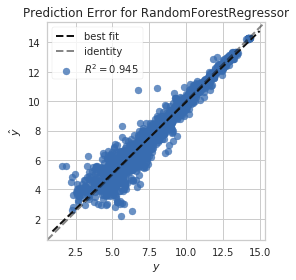

In [511]:
from yellowbrick.regressor import PredictionError
from yellowbrick.style import set_palette

set_palette('accent')

for name, estimator in ESTIMATORS.items():
    plot_error_prediction(estimator, X_train, y_train, X_test, y_test)

In [543]:
df['views'].max()

1825923.6169157613

# Evaluating the models performance


- Random Forest: Best R2 and adjusted R2, good Median Absolute Error. However high RMSE and Mean Absolute Error.
- K-nn: lowest scores and the features should've been scaled (tested robust scaler but this resulted in bad metrics).
- Extra Tree: really close r2 scores to the Random forest but better RMSE and MAE compared to other models. 

Overall all the models are behaving great considering our target ranges from 3 - 1825923. We will try more options for the (Extra Tree and Random Forest) to see which can give us the best results.

# Tuning our model and getting the best possible parameter

In [529]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200, 300, 400]
# Number of features to consider at every split
max_features = ['auto', 'sqrt', 'log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 3, 4, 5, 8, 10, 11]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [1, 2, 4, 8, 16, 32, 64, 100, 200, 300, 400, 500, 600], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 3, 4, 5, 8, 10, 11], 'min_samples_leaf': [1, 2, 4]}


In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = ExtraTreesRegressor(n_jobs=1, random_state=RANDOM_STATE)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, 
                               param_distributions = random_grid,
                               n_iter = 100, cv = 3, verbose=2,
                               scoring='neg_mean_squared_error', random_state=RANDOM_STATE, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

# already run this but I've removed the output is too long

In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf_2 = RandomForestRegressor(n_jobs=1, random_state=42)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random_2 = RandomizedSearchCV(estimator = rf_2, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random_2.fit(X_train, y_train)

# already run this but I've removed the output cause it's too long

In [555]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    exp_y_pred = np.expm1(predictions)
    exp_y_test = np.expm1(test_labels)
    errors = abs(exp_y_pred - exp_y_test)
    mape = 100 * np.mean(errors / exp_y_test)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

In [556]:
rf_random.best_params_

{'n_estimators': 300,
 'min_samples_split': 11,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 40,
 'bootstrap': False}

In [561]:
rf_random_2.best_params_

{'n_estimators': 500,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 90,
 'bootstrap': True}

In [23]:
model_best_extra = ExtraTreesRegressor(n_jobs=1, random_state=0, n_estimators= 300,
 min_samples_split = 11,
 min_samples_leaf = 1,
 max_features = 'auto',
 max_depth = 40,
 bootstrap =False)
generate_model_report(model_best_extra, X_train, y_train, X_test, y_test)


{'R2': 0.9579797824573206,
 'RMSE': 18453.601568585265,
 'Median_Absolute_Error': 603.4202371912388,
 'MAE': 5291.066539589748,
 'Adjusted_R2': 0.9569901011805548,
 'RMSE_Train': 11074.553592487846,
 'MAE_Train': 3706.9817435763107}

In [560]:
base_model = ExtraTreesRegressor( random_state = RANDOM_STATE)
base_model.fit(X_train, y_train)
base_accuracy = evaluate(base_model, X_test, y_test)
random_accuracy = evaluate(model_best_extra, X_test, y_test)

print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))


Model Performance
Average Error: 5792.4938 degrees.
Accuracy = 47.58%.
Model Performance
Average Error: 5291.0665 degrees.
Accuracy = 53.83%.
Improvement of 13.12%.


In [563]:
model_best_random = RandomForestRegressor(n_jobs=1, random_state=0, n_estimators= 200,
 min_samples_split = 5,
 min_samples_leaf = 1,
 max_features = 'auto',
 max_depth = 30,
 bootstrap = True)
generate_model_report(model_best_random, X_train, y_train, X_test, y_test)

{'R2': 0.9537348350434339,
 'RMSE': 18430.78192732255,
 'Median_Absolute_Error': 628.60632714891,
 'MAE': 5866.329449094583,
 'Adjusted_R2': 0.9526451746322881,
 'RMSE_Train': 10048.464837234567,
 'MAE_Train': 3256.6637824692425}

In [564]:
base_model = RandomForestRegressor( random_state = RANDOM_STATE)
base_model.fit(X_train, y_train)
base_accuracy = evaluate(base_model, X_test, y_test)
random_accuracy = evaluate(model_best_random, X_test, y_test)

print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))


Model Performance
Average Error: 6442.7633 degrees.
Accuracy = 45.29%.
Model Performance
Average Error: 5866.3294 degrees.
Accuracy = 49.94%.
Improvement of 10.29%.


#### Lets interpret the results:

#####  Interpreting the root mean squared error:
our results are usually off by 18 thousands visits for random forest and extra trees (Note how this is panelizing our outliers)

#####  Interpreting the mean absolute error :
we added the mean absolute error casue it's robust against outliers and we are off by 5866 views for the random forest and 5291 for extra trees

#####  Interpreting the r2 adjusted :
we added adjusted r2 because it takes into consideration how many independent variables are there in our model and then how it's accuratly explaining the variability to our dependent variable with a pecent of 95 for the random forest and 96 for the extra trees.



In [565]:
from yellowbrick.style.palettes import PALETTES, SEQUENCES, color_palette

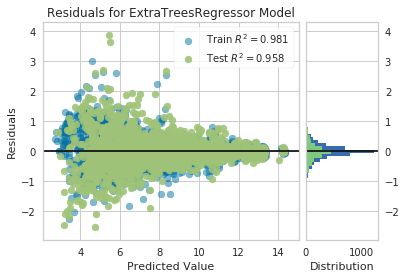

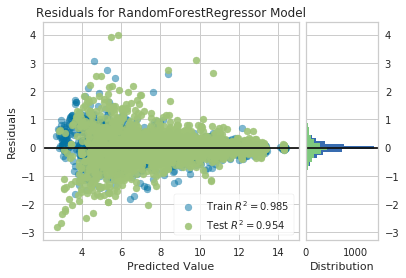

In [566]:
plot_visualizer(model_best_extra, X_train, y_train, X_test, y_test)
plot_visualizer(model_best_random, X_train, y_train, X_test, y_test)

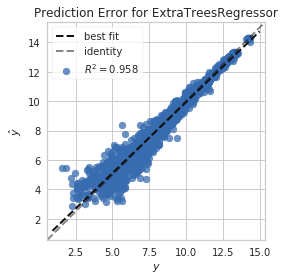

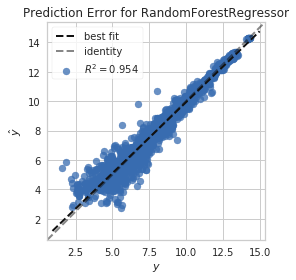

In [567]:
plot_error_prediction(model_best_extra, X_train, y_train, X_test, y_test)
plot_error_prediction(model_best_random, X_train, y_train, X_test, y_test)

In [568]:
# Plot boxplot based on top 5 listed categories 
# Those were chosen to allow a fair distribution of samples
columns = ['y True', 'y Extra Tree','y Random Forest'
         , 'y_test']
x_data = columns
y_data = []
colors = []
y_data.append(y_test)
y_data.append(model_best_extra.predict(X_test))
y_data.append(model_best_random.predict(X_test))
colors = ['rgba(93, 164, 214, 0.5)', 'rgba(255, 144, 14, 0.5)', 'rgba(44, 160, 101, 0.5)']
traces = []

# Generate box plot for each group
for xd, yd, cls in zip(x_data, y_data, colors):
        traces.append(go.Box(
            y=yd,
            name=xd,
            boxpoints='all',
            jitter=0.5,
            whiskerwidth=0.2,
            fillcolor=cls,
            marker=dict(
                size=2,
            ),
            line=dict(width=1),
        ))

# Set up the layout
layout = go.Layout(
    title='Comparing Y test results',
    yaxis=dict(
        autorange=True,
        showgrid=True,
        zeroline=True,
        dtick=5,
        gridcolor='rgb(255, 255, 255)',
        gridwidth=1,
        zerolinecolor='rgb(255, 255, 255)',
        zerolinewidth=2,
    ),
    margin=dict(
        l=40,
        r=30,
        b=80,
        t=100,
    ),
    paper_bgcolor='rgb(243, 243, 243)',
    plot_bgcolor='rgb(243, 243, 243)',
    showlegend=False
)

fig = go.Figure(data=traces, layout=layout)
py.iplot(fig)

In [569]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


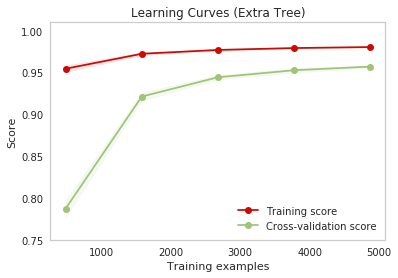

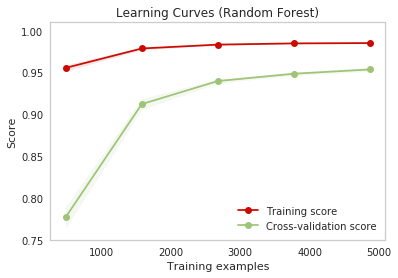

In [571]:


title = "Learning Curves (Extra Tree)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=10, test_size=0.3, random_state=RANDOM_STATE)
plot_learning_curve(model_best_extra, title, X, y, ylim=(0.75, 1.01), cv=cv, n_jobs=4)

title = "Learning Curves (Random Forest)"
plot_learning_curve(model_best_random, title, X, y, (0.75, 1.01), cv=cv, n_jobs=4)

plt.show()


### After Various comparison we will select Extra Tree because:
- Faster than the Random Forest
- Extra tree has better scores (R2 - MAE)
- Cross validation scores are more consistent with Extra Trees

## Try and improve more using the gridsearchcv 

In [530]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
max_features = ['auto', 'sqrt']
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,}
# Create a based model
rf = ExtraTreesRegressor(random_state = 0, bootstrap=False)
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = random_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [ ]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train)
grid_search.best_params_

best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, X_test, y_test)


In [553]:
grid_search.best_params_

{'max_depth': 60,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 8,
 'n_estimators': 100}

In [28]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [29]:
mean_absolute_percentage_error(np.expm1(y_test), np.expm1(model_best_extra.predict(X_test)))


46.174006317684565

In [554]:
model_best_extra = ExtraTreesRegressor(n_jobs=1, random_state=0, n_estimators= 100,
 min_samples_split = 8,
 min_samples_leaf = 1,
 max_features = 'auto',
 max_depth = 60,
 bootstrap =False)
generate_model_report(model_best_extra, X_train, y_train, X_test, y_test)

{'R2': 0.9573447965983037,
 'RMSE': 17617.90305936208,
 'Median_Absolute_Error': 565.3202126449069,
 'MAE': 5282.345506231922,
 'Adjusted_R2': 0.9563401598155357,
 'RMSE_Train': 9562.935637332657,
 'MAE_Train': 3168.6393393167423}

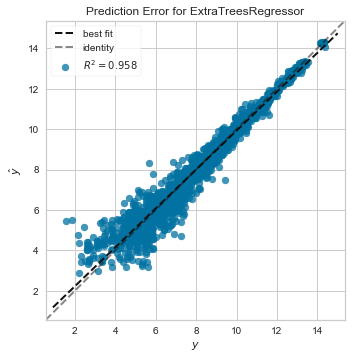

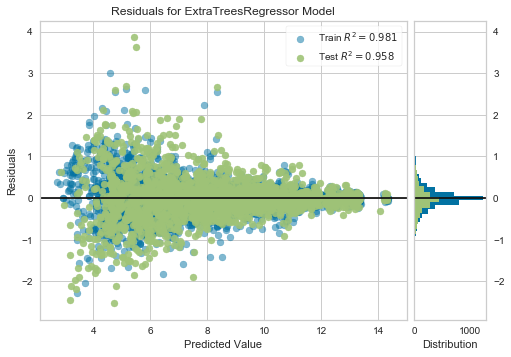

In [26]:
plot_error_prediction(model_best_extra, X_train, y_train, X_test, y_test)
plot_visualizer(model_best_extra, X_train, y_train, X_test, y_test)

In [572]:
importance_df = pd.DataFrame({'features': X_train.columns , 'importance': model_best_extra.feature_importances_})

In [573]:
importance_df.sort_values(by='importance', ascending = False).head(11)

features  importance
45                links_in_count    0.364381
40               followers_count    0.201041
43                         likes    0.043387
47                       replies    0.032134
9                             EG    0.025057
33                      Shopping    0.022137
44                         links    0.019280
13              Health & Fitness    0.018698
17                            JO    0.018643
30                            SA    0.016630
23  News / Weather / Information    0.016150

In [574]:
importances = model_best_extra.feature_importances_
trace = go.Bar(x=importance_df.sort_values(by='importance'
                                           , ascending = False).iloc[:11,:].features
               , y=importance_df.sort_values(by='importance', ascending = False).iloc[:11,:].importance,
               marker=dict(color='red'), opacity=0.5
              )

layout = go.Layout(title="Feature importances")
fig = go.Figure(data=[trace], layout=layout)
py.iplot(fig, filename='model_best_extra')

## Making sense of the feature importance:
- links_in_count: this gives us a hint to how widespread\popular the company website is 
- followers_count: this will relate to how active this company is on twitter
- Shopping: as we saw earlier in the box plot the shopping category was one of height in terms of traffic so it makes absolute sense for it's importance


A possible rout we could've take was scaling the features, however citing this article https://medium.com/greyatom/why-how-and-when-to-scale-your-features-4b30ab09db5e
"Tree based models are not distance based models and can handle varying ranges of features. Hence, Scaling is not required while modelling trees." 

# Another model without any of amazon service features
lets try and create a model that doesn't require any data from amazon web service


In [575]:
X_cheaper = X = X[X.columns.difference(['links_in_count'])]

In [576]:
X_train, X_test, y_train, y_test = train_test_split( X_cheaper, y, test_size=0.3, random_state=RANDOM_STATE)

In [577]:
model_cheaper = model_best_extra

generate_model_report(model_cheaper, X_train, y_train, X_test, y_test)

{'R2': 0.9482782616921435,
 'RMSE': 27157.871240315337,
 'Median_Absolute_Error': 690.8786208971578,
 'MAE': 6398.774639364868,
 'Adjusted_R2': 0.9470860489896082,
 'RMSE_Train': 17255.83492779638,
 'MAE_Train': 4739.229628410389}

In [578]:
importance_df_2 = pd.DataFrame({'features': X_train.columns , 'importance': model_cheaper.feature_importances_})
importance_df_2.sort_values(by='importance', ascending = False).head(11)

features  importance
40               followers_count    0.338665
43                         likes    0.084743
46                       replies    0.058776
30                            SA    0.051135
44                         links    0.033786
17                            JO    0.033105
33                      Shopping    0.029352
41                hashtags_count    0.026086
26              Personal Finance    0.022566
23  News / Weather / Information    0.022564
9                             EG    0.020223

In [579]:
importances = model_cheaper.feature_importances_
trace = go.Bar(x=importance_df_2.sort_values(by='importance'
                                           , ascending = False).iloc[:11,:].features
               , y=importance_df_2.sort_values(by='importance', ascending = False).iloc[:11,:].importance,
               marker=dict(color='purple'), opacity=0.5
              )

layout = go.Layout(title="Feature importances")
fig = go.Figure(data=[trace], layout=layout)
py.iplot(fig, filename='large')

# Conclusion
An important aspect in the world of website traffic calculations is that all platforms providing this service dont promise 100% accuracy. One think to take from this is one way of cutting costs is training a model to predict such data without having to rely on third party services from other companies. and having your own tool to predict website traffic for competitors or potential invsitments in other companies.